# Notebook for alignment analysis

Imports

In [2]:
import time
import os
import importlib

from pprint import pprint
from collections import defaultdict
from pathlib import Path
import re
import json

from more_itertools import grouper
from itertools import islice, chain, zip_longest, repeat

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy import io
from scipy.signal import convolve
from scipy.sparse import coo_matrix, csr_matrix
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import cut_tree

from statsmodels.stats import multitest

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

import pyBigWig
import pysam

from Modules import utils, plot_utils

Useful global variables

In [3]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams.update({'axes.labelsize': 16})

Name of chromosomes in GRCh38 and T2T-CHM13v2.0
Header for BigWig files, with chromosome lengths

In [4]:
hg38_chr_ids = {
    1: 'NC_000001.11',
    2: 'NC_000002.12',
    3: 'NC_000003.12',
    4: 'NC_000004.12',
    5: 'NC_000005.10',
    6: 'NC_000006.12',
    7: 'NC_000007.14',
    8: 'NC_000008.11',
    9: 'NC_000009.12',
    10: 'NC_000010.11',
    11: 'NC_000011.10',
    12: 'NC_000012.12',
    13: 'NC_000013.11',
    14: 'NC_000014.9',
    15: 'NC_000015.10',
    16: 'NC_000016.10',
    17: 'NC_000017.11',
    18: 'NC_000018.10',
    19: 'NC_000019.10',
    20: 'NC_000020.11',
    21: 'NC_000021.9',
    22: 'NC_000022.11',
    'X': 'NC_000023.11',
    'Y': 'NC_000024.10',}
T2T_chr_ids = {
    1: 'NC_060925.1',
    2: 'NC_060926.1',
    3: 'NC_060927.1',
    4: 'NC_060928.1',
    5: 'NC_060929.1',
    6: 'NC_060930.1',
    7: 'NC_060931.1',
    8: 'NC_060932.1',
    9: 'NC_060933.1',
    10: 'NC_060934.1',
    11: 'NC_060935.1',
    12: 'NC_060936.1',
    13: 'NC_060937.1',
    14: 'NC_060938.1',
    15: 'NC_060939.1',
    16: 'NC_060940.1',
    17: 'NC_060941.1',
    18: 'NC_060942.1',
    19: 'NC_060943.1',
    20: 'NC_060944.1',
    21: 'NC_060945.1',
    22: 'NC_060946.1',
    'X': 'NC_060947.1',
    'Y': 'NC_060948.1',}
sacCer3_chr_ids = {
    1: 'I',
    2: 'II',
    3: 'III',
    4: 'IV',
    5: 'V',
    6: 'VI',
    7: 'VII',
    8: 'VIII',
    9: 'IX',
    10: 'X',
    11: 'XI',
    12: 'XII',
    13: 'XIII',
    14: 'XIV',
    15: 'XV',
    16: 'XVI',}
# {"NC_060925.1":"1", "NC_060926.1":"2", "NC_060927.1":"3", "NC_060928.1":"4", "NC_060929.1":"5", "NC_060930.1":"6", "NC_060931.1":"7", "NC_060932.1":"8", "NC_060933.1":"9", "NC_060934.1":"10", "NC_060935.1":"11", "NC_060936.1":"12", "NC_060937.1":"13", "NC_060938.1":"14", "NC_060939.1":"15", "NC_060940.1":"16", "NC_060941.1":"17", "NC_060942.1":"18", "NC_060943.1":"19", "NC_060944.1":"20", "NC_060945.1":"21", "NC_060946.1":"22", "NC_060947.1":"X", "NC_060948.1":"Y"}

Parse bam files and save in npz format

In [5]:
data = 'CTCF'
genome = 'T2T-CHM13v2.0'
ip_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, 'IP_paired_T2T.sorted.bam'))
ctrl_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, 'Control_paired_T2T.sorted.bam'))
ip_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_IP_coord_all_chr.npz')
ctrl_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_Control_coord_all_chr.npz')
if not ip_npz_file.is_file():
    np.savez_compressed(ip_npz_file, **ip_coord)
if not ctrl_npz_file.is_file():
    np.savez_compressed(ctrl_npz_file, **ctrl_coord)


0/13154074 reads rejected
0/24641372 reads rejected


Parse single-end bam files and save in npz format

In [147]:
data = 'RNAPII_quiescence' 
genome = 'sacCer3'
ip_coord = utils.parse_bam(Path(data_dir, data, 'bam_cer_only', f'untagged_expo_IP_1.cer.3MM.bam'), paired=False, fragment_length=0)
# ctrl_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, f'untagged_expo_INPUT_1.sorted.bam'), paired=False, fragment_length=0)
ip_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'untagged_expo_IP_1.cer.3MM_coord_all_chr.npz')
ctrl_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'untagged_expo_INPUT_1_coord_all_chr.npz')
if not ip_npz_file.is_file():
    np.savez_compressed(ip_npz_file, **ip_coord)
if not ctrl_npz_file.is_file():
    np.savez_compressed(ctrl_npz_file, **ctrl_coord)
# for i in range(30, 38):
#     ip_access = f'SRR146783{i+8}'
#     ctrl_access = f'SRR146783{i}'
#     ip_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, f'{ip_access}_T2T.sorted.bam'), paired=False, fragment_length=250)
#     ctrl_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, f'{ctrl_access}_T2T.sorted.bam'), paired=False, fragment_length=250)
#     ip_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ip_access}_{genome}_IP_coord_all_chr.npz')
#     ctrl_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ctrl_access}_{genome}_Control_coord_all_chr.npz')
#     if not ip_npz_file.is_file():
#         np.savez_compressed(ip_npz_file, **ip_coord)
#     if not ctrl_npz_file.is_file():
#         np.savez_compressed(ctrl_npz_file, **ctrl_coord)

[W::hts_idx_load3] The index file is older than the data file: ../shared_folder/RNAPII_quiescence/bam_cer_only/untagged_expo_IP_1.cer.3MM.bam.bai


0/8181821 reads rejected


Plot fragment lengths

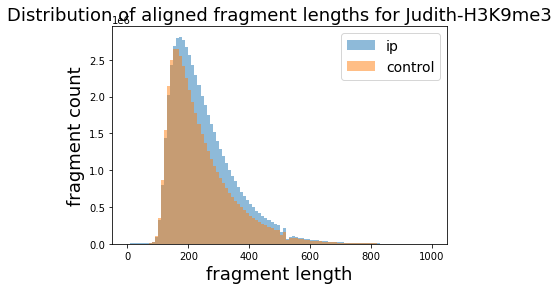

In [49]:
data = 'Judith-H3K9me3'
genome = 'T2T-CHM13v2.0'
with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_IP_coord_all_chr.npz')) as f:
    ip_lengths = []
    for key in f.keys():
        ip_lengths.append(np.diff(f[key], axis=1).ravel())
    ip_lengths = np.concatenate(ip_lengths)
with np.load(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_Control_coord_all_chr.npz')) as f:
    ctrl_lengths = []
    for key in f.keys():
        ctrl_lengths.append(np.diff(f[key], axis=1).ravel())
    ctrl_lengths = np.concatenate(ctrl_lengths)
plt.hist(ip_lengths, bins=100, range=(0, 1000), label='ip', alpha=0.5)
plt.hist(ctrl_lengths, bins=100, range=(0, 1000), label='control', alpha=0.5)
plt.legend(fontsize=14)
plt.title(f'Distribution of aligned fragment lengths for {data}', fontsize=18)
plt.xlabel('fragment length', fontsize=18)
plt.ylabel('fragment count', fontsize=18)
fig_name = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_fragment_length_distribution.png')
fig_name = utils.safe_filename(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

Convert to roman numerals

In [ ]:
#### Convert to roman
# chr_coords = {}
# with np.load(Path(data_dir, data, 'results', 'alignments', genome, 'untagged_expo_IP_1.cer.3MM_coord_all_chr.npz')) as f:
#     for key in f.keys():
#         try:
#             chr_coords[f'chr{utils.int_to_roman(int(key[3:]))}'] = f[key]
#         except KeyError:
#             print(f'{key} is unused')
# np.savez_compressed(Path(data_dir, data, 'results', 'alignments', genome, 'untagged_expo_IP_1.cer.3MM_roman_coord_all_chr.npz'),
#                     **chr_coords)

#### Convert to int
chr_coords = {}
with np.load(Path(data_dir, data, 'results', 'alignments', genome, 'untagged_expo_IP_1_coord_all_chr.npz')) as f:
    for key in f.keys():
        if key=='chrM':
            print(f'{key} is unused')
            continue
        try:
            chr_coords[f'chr{utils.roman_to_int(key[3:]):02}'] = f[key]
        except KeyError:
            print(f'{key} is unused')
# np.savez_compressed(Path(data_dir, data, 'results', 'alignments', genome, 'untagged_expo_IP_1_arabic_coord_all_chr.npz'),
#                     **chr_coords)

Custom alignment analysis with specified binsize

In [ ]:
data = 'Judith-H3K4me3'
genome = 'T2T-CHM13v2.0'
ip_coord_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_IP_coord_all_chr.npz')
ctrl_coord_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_Control_coord_all_chr.npz')
chr_sizes_file = Path(data_dir, 'Human', 'assembly', genome, f'{genome}_chrom_sizes.json')
max_frag_len = 500
binsize = 50000
out_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_maxfraglen_{max_frag_len}_binsize_{binsize}.csv')
utils.genome_enrichment(ip_coord_file, ctrl_coord_file, chr_sizes_file, out_file, max_frag_len, binsize)

In [293]:
data = 'RNAPII_quiescence'
genome = 'sacCer3'
chr_sizes_file = Path(data_dir, 'SCerevisiae', 'genome', f'{genome}_chrom_sizes.json')
max_frag_len = 500
binsize = 50

ip_prefix = 'untagged_expo_IP_1'
ctrl_prefix = 'untagged_expo_INPUT_1'
ip_coord_file = Path(data_dir, data, 'results', 'alignments', genome, f'{ip_prefix}_coord_all_chr.npz')
ctrl_coord_file = Path(data_dir, data, 'results', 'alignments', genome, f'{ctrl_prefix}_coord_all_chr.npz')
out_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_{ip_prefix}_vs_{ctrl_prefix}_maxfraglen_{max_frag_len}_binsize_{binsize}.csv')
utils.genome_enrichment(ip_coord_file, ctrl_coord_file, chr_sizes_file, out_file, max_frag_len, binsize)
# for i in range(30, 38):
#     ip_access = f'SRR146783{i+8}'
#     ctrl_access = f'SRR146783{i}'
#     ip_coord_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ip_access}_{genome}_IP_coord_all_chr.npz')
#     ctrl_coord_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ctrl_access}_{genome}_Control_coord_all_chr.npz')
#     out_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ip_access}_{genome}_maxfraglen_{max_frag_len}_binsize_{binsize}.csv')
#     utils.genome_enrichment(ip_coord_file, ctrl_coord_file, chr_sizes_file, out_file, max_frag_len, binsize)

Load alignment results and get chromosome separators

In [520]:
data = 'RNAPII_quiescence'
genome = 'sacCer3'
max_frag_len = 500
binsize = 50
ip_prefix = 'untagged_expo_IP_1'
ctrl_prefix = 'untagged_expo_INPUT_1'
df = pd.read_csv(
    Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_{ip_prefix}_vs_{ctrl_prefix}_maxfraglen_{max_frag_len}_binsize_{binsize}.csv'),
    index_col=[0, 1])
# Change roman numerals to int in chromosome index, and sort indices
df.index = df.index.set_levels(['chr' + format(utils.roman_to_int(key[3:]), '02d') for key in df.index.levels[0]], level=0)
df = df.sort_index()
# separators = np.append(np.where(df['pos'] == 0)[0], len(df))
df

ip_count  ctrl_count      pval      qval
chr   pos                                             
chr01 0             10          33  0.997846  1.000000
      50            43          80  0.970665  1.000000
      100           27          56  0.979718  1.000000
      150           33          33  0.150004  1.000000
      200           37          36  0.111407  0.919706
...                ...         ...       ...       ...
chr16 947850        22          88  1.000000  1.000000
      947900        28         108  1.000000  1.000000
      947950        47         219  1.000000  1.000000
      948000        16          81  1.000000  1.000000
      948050         0           0  1.000000  1.000000

[241434 rows x 4 columns]

In [ ]:
data = 'H3K9me3-GSE175752'
genome = 'T2T-CHM13v2.0'
max_frag_len = 500
binsize = 50000

H3K9me3_Rechem = []
for i in range(30, 38):
    access = f'SRR146783{i+8}'
    df = pd.read_csv(
        Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{access}_{genome}_maxfraglen_{max_frag_len}_binsize_{binsize}.csv'),
        index_col=0)
    H3K9me3_Rechem.append(df)

Extra computations

In [721]:
df['norm_ip_cov'] = df['ip_count'] / np.sum(df['ip_count'])
df['norm_ctrl_cov'] = df['ctrl_count'] / np.sum(df['ctrl_count'])
df["signif_pval"] = df['pval']<0.05
df["signif_qval"] = df['qval']<0.05
df["-log_pval"] = -np.log10(df['pval'])
df["-log_qval"] = -np.log10(df['qval'])

Genome-wide comparison plot

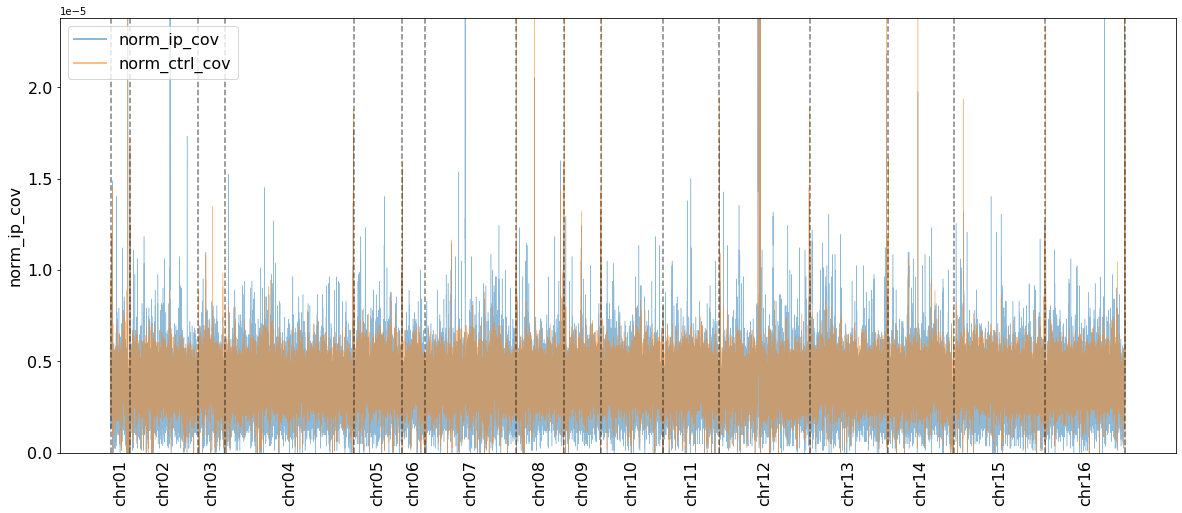

In [728]:
start = ('chr01', 0)
stop = ('chr16', df.index.levels[1].max())
columns = ['norm_ip_cov', 'norm_ctrl_cov']

subdf = df.loc[start:stop, columns]
subdf.index = subdf.index.remove_unused_levels()
separators = np.insert(np.cumsum(np.array(subdf[columns[0]].groupby(level=0).count())), 0, 0)
lim = np.quantile(subdf[columns[0]], 0.99)*3 # 1
xtick_positions = False
xtick_rotated = True
if start[0] == stop[0]:
    xtick_positions = True
    xtick_rotated = False
# plot
ax = subdf.plot(
    figsize=(20, 8),
    xlabel='positions',
    ylabel=columns[0],
    ylim=(0, lim),
    alpha=0.5,
    linewidth=0.5,
    fontsize=16)
# legend with different line width
leg = ax.legend(fontsize=16)
for line in leg.get_lines():
    line.set_linewidth(2)
# Horizotal and vertical lines
for sep in separators:
    ax.axvline(x=sep, color='black', linestyle='--', alpha=0.5)
# Get default ticks for genome position
if xtick_positions:
    xticks = ax.get_xticks()
    xticks_minor = xticks[np.where((0 <= xticks) & (xticks <= separators[-1]))]
    xticklabels_minor = [subdf.index[int(t)][1] for t in xticks_minor]
    ax.set_xticks(xticks_minor, labels=xticklabels_minor, minor=True)
# Add ticks for chromosome
xticks = utils.moving_average(separators)
if xtick_rotated:
    rot = 90
    xticklabels = subdf.index.levels[0]
else:
    rot = 0
    xticklabels = list('\n' + subdf.index.levels[0])
ax.set_xticks(xticks, labels=xticklabels, rotation=rot, fontsize=16)
ax.tick_params( axis='x', which='major', bottom=False, top=False )
# Remove xlabel
ax.set_xlabel(None)
plt.show()
plt.close()

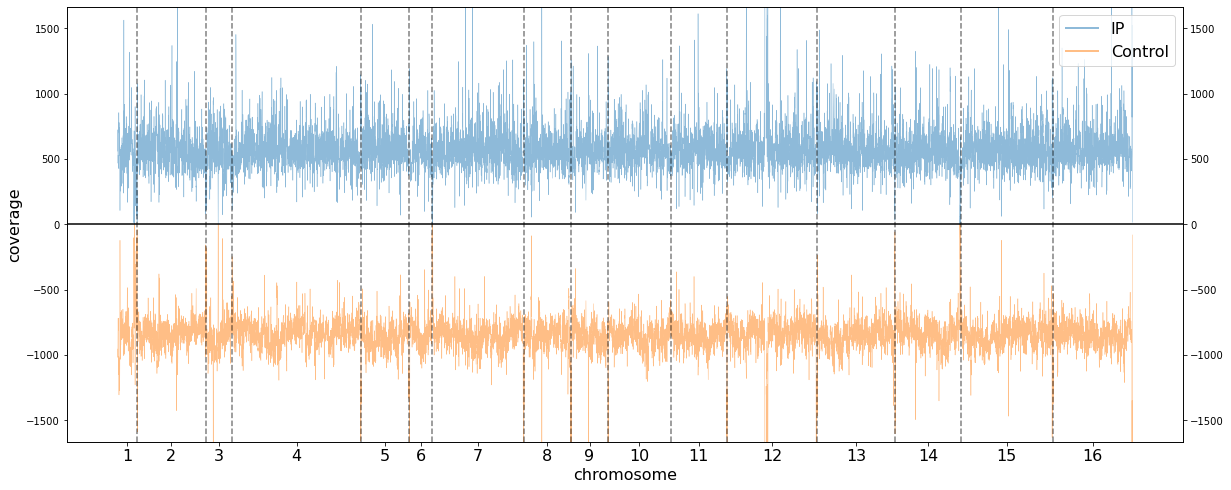

In [237]:
start = separators[0]*binsize #+ 138_000_000
stop = separators[-1]*binsize #+ 152_000_000
column = 'ip_count' # 'ip_count' # 'signif_qval'
column2 = "ctrl_count"
values_list = [df[column], -df[column2]]
label_list = ['IP', 'Control']

if genome == 'T2T-CHM13v2.0':
    chr_ids = T2T_chr_ids
elif genome == 'GRCh38':
    chr_ids = hg38_chr_ids
elif genome == 'sacCer3':
    chr_ids = sacCer3_chr_ids
plt.figure(figsize=(20, 8))
axes = plot_utils.compare_binned_plots(values_list, label_list, start, stop, binsize, alpha=0.5, linewidth=0.5)
lim = np.quantile(df[column], 0.99)*1.5 # 1
axes[0].set_ylim(bottom=-lim, top=lim)
axes[1].set_ylim(bottom=-lim, top=lim)
for sep in separators[1:-1]:
    plt.axvline(x=sep*binsize, color='black', linestyle='--', alpha=0.5)
axes[0].set_xticks(utils.moving_average(separators*binsize)[:])
axes[0].set_xticklabels(list(chr_ids.keys())[:], fontsize=16)
axes[0].set_xlabel('chromosome', fontsize=16)
axes[0].set_ylabel('coverage', fontsize=16)
plt.axhline(y=0, color='black')
plt.show()
plt.close()

<AxesSubplot:title={'center':'Significant p-value distribution on CTCF with binsize 50 and full coverage'}, ylabel='Frequency'>

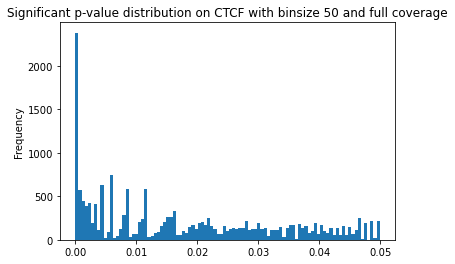

In [180]:
df['pval'][df['pval']<0.05].plot(
    kind='hist',
    bins=97,
    grid=False,
    xlabel='p-value',
    title=f'Significant p-value distribution on CTCF with binsize {binsize} and full coverage')

<AxesSubplot:title={'center':'Significant p-value distribution on CTCF with binsize 50 and full coverage'}, ylabel='Frequency'>

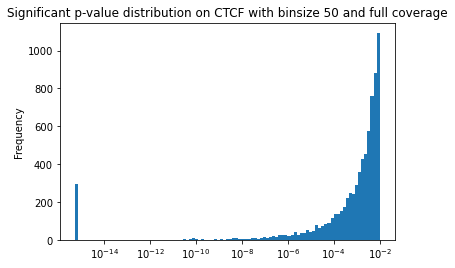

In [179]:
subdf = df['pval'][df['pval']<1e-2]
logbins = np.geomspace(subdf.min(), subdf.max(), 100)
subdf.plot(
    kind='hist',
    bins=logbins,
    grid=False,
    logx=True,
    xlabel='p-value',
    title=f'Significant p-value distribution on CTCF with binsize {binsize} and full coverage')

In [83]:
subdf = df[(df['pval']<1e-15)].loc[:, ['ip_count', 'ctrl_count', 'pval']]
print(len(subdf[subdf['ip_count'] >= 30]), len(subdf))
subdf

2888 3134


,ip_count,ctrl_count,pval
74,34.0,0.0,1.110223e-16
76,33.0,1.0,1.110223e-16
727,50.0,5.0,1.110223e-16
728,46.0,6.0,1.110223e-16
737,38.0,4.0,4.440892e-16
...,...,...,...
57930371,38.0,4.0,4.440892e-16
60078194,32.0,0.0,1.110223e-16
60078197,29.0,0.0,7.771561e-16
62345368,37.0,1.0,1.110223e-16


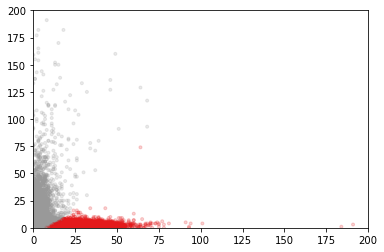

In [57]:
# Show significant enrichments based on ip and ctrl coverage
plt.scatter(df["ip_count"], df["ctrl_count"], c=df["signif_qval"], label='positions', cmap=plt.cm.get_cmap('Set1_r'), marker='.', alpha=0.2)
plt.xlim(left=0, right=200)
plt.ylim(bottom=0, top=200)
plt.show()
plt.close()

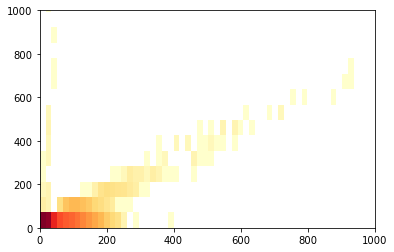

In [119]:
_, bin_edges_x = np.histogram(df["ip_count"], bins=100)
_, bin_edges_y = np.histogram(df["ctrl_count"], bins=100)
bin_edges = [bin_edges_x, bin_edges_y]
plt.hist2d(df["ip_count"], df["ctrl_count"], bins=bin_edges, density=True, norm=mpl.colors.LogNorm(), cmap=plt.cm.get_cmap('YlOrRd'))
plt.xlim(left=0, right=1000)
plt.ylim(bottom=0, top=1000)
plt.show()
plt.close()

## Granularity analysis

In [356]:
data = 'RNAPII_quiescence'
genome = 'sacCer3'
max_frag_len = 500
ip_prefix = 'untagged_expo_IP_1'
ctrl_prefix = 'untagged_expo_INPUT_1'
binsizes = [50, 200, 1000, 5000, 50000]
binsize = binsizes[0]
df_all = pd.read_csv(
    Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_{ip_prefix}_vs_{ctrl_prefix}_maxfraglen_{max_frag_len}_binsize_{binsize}.csv'),
    index_col=[0, 1]
).rename(columns={'pval': f'pval_{binsize}', 'qval': f'qval_{binsize}'}
).drop(['ip_count', 'ctrl_count'], axis=1)
for b in binsizes[1:]:
    df_adapt = pd.read_csv(
        Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{genome}_{ip_prefix}_vs_{ctrl_prefix}_maxfraglen_{max_frag_len}_binsize_{b}.csv'),
        index_col=[0, 1])
    df_adapt = utils.adapt_to_bins(
        df_adapt, df_all, b, binsize
    ).rename(columns={'pval': f'pval_{b}', 'qval': f'qval_{b}'})
    df_all.loc[:, [f'pval_{b}', f'qval_{b}']] = df_adapt.loc[:, [f'pval_{b}', f'qval_{b}']]
df_all

pval_50   qval_50  pval_200  qval_200  pval_1000  qval_1000  \
chr    pos                                                                    
chrI   0       0.997846  1.000000  0.995415       1.0   0.999999        1.0   
       50      0.970665  1.000000  0.995415       1.0   0.999999        1.0   
       100     0.979718  1.000000  0.995415       1.0   0.999999        1.0   
       150     0.150004  1.000000  0.995415       1.0   0.999999        1.0   
       200     0.111407  0.919706  0.981166       1.0   0.999999        1.0   
...                 ...       ...       ...       ...        ...        ...   
chrXVI 947850  1.000000  1.000000  1.000000       1.0   1.000000        1.0   
       947900  1.000000  1.000000  1.000000       1.0   1.000000        1.0   
       947950  1.000000  1.000000  1.000000       1.0   1.000000        1.0   
       948000  1.000000  1.000000  1.000000       1.0   1.000000        1.0   
       948050  1.000000  1.000000  1.000000       1.0   1.000000        1.0   

               pval_5000  qval_5000  pval_50000  qval_50000  
chr    pos                                                   
chrI   0        1.000000        1.0         1.0         1.0  
       50       1.000000        1.0         1.0         1.0  
       100      1.000000        1.0         1.0         1.0  
       150      1.000000        1.0         1.0         1.0  
       200      1.000000        1.0         1.0         1.0  
...                  ...        ...         ...         ...  
chrXVI 947850   0.999989        1.0         1.0         1.0  
       947900   0.999989        1.0         1.0         1.0  
       947950   0.999989        1.0         1.0         1.0  
       948000   0.999989        1.0         1.0         1.0  
       948050   0.999989        1.0         1.0         1.0  

[241434 rows x 10 columns]

In [238]:
key = 'p'
df_signif = df_all.loc[:, [f'{key}val_{b}' for b in [50, 200, 1000, 5000, 50000]]] < 0.05
signif_by_binsize = df_signif.sum(axis=0)
signif_by_pos = df_signif.sum(axis=1)
signif_by_binsize

pval_50       18111
pval_200      32548
pval_1000     45000
pval_5000     29700
pval_50000     2000
dtype: int64

In [266]:
tuples = [(1, 0), (1, 50), (1, 100), (2, 0), (3, 0), (3, 50)]
index = pd.MultiIndex.from_tuples(tuples)
pd.Series(np.random.randn(6), index=index)

1  0     -0.012333
   50    -0.350264
   100   -0.049656
2  0     -0.313436
3  0      0.725239
   50    -0.779801
dtype: float64

In [275]:
# index = pd.MultiIndex()
chr_lens = {'chr1': 246, 'chr2': 132, 'chr3': 196}
binsize = 50
binned_chr_lens = np.array([x // binsize + 1 for x in chr_lens.values()])

index = pd.MultiIndex.from_tuples(
    [(chr_id, pos)
        for chr_id in np.arange(len(chr_lens))
        for pos in np.arange(0, binned_chr_lens[chr_id]*binsize, binsize)],
    names = ['chr', 'pos']
)
index

MultiIndex([(0,   0),
            (0,  50),
            (0, 100),
            (0, 150),
            (0, 200),
            (1,   0),
            (1,  50),
            (1, 100),
            (2,   0),
            (2,  50),
            (2, 100),
            (2, 150)],
           names=['chr', 'pos'])

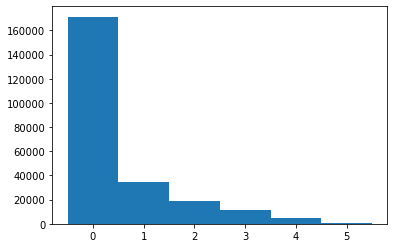

[171381  34905  18619  11339   4751    439]


In [239]:
plt.hist(signif_by_pos, bins=np.arange(-0.5, 6.5))
plt.show()
plt.close()
print(np.histogram(signif_by_pos, bins=np.arange(-0.5, 6.5))[0])

In [254]:
df_coincide = pd.DataFrame(index=binsizes, columns=np.arange(5))
for b in df_coincide.index:
    for l in df_coincide.columns:
        df_coincide.loc[b, l] = len(df_signif[(df_signif[f'{key}val_{b}'] == 1) & (signif_by_pos == l+1)])
csv_name = utils.safe_filename(Path(data_dir, data, 'results', 'alignments', genome, f'{data}_enrichment_coincidence_{key}val.csv'))
df_coincide.to_csv(csv_name)
df_coincide

,0,1,2,3,4
50,3125,3624,6241,4682,439
200,5339,11282,10747,4741,439
1000,14037,14920,10865,4739,439
5000,11524,7050,5970,4717,439
50000,880,362,194,125,439


In [259]:
# df_signif.groupby(df_signif.columns.tolist(), as_index=False).size()
df_signif.value_counts()

pval_50  pval_200  pval_1000  pval_5000  pval_50000
False    False     False      False      False         171381
                   True       False      False          14037
                   False      True       False          11524
         True      True       False      False           8114
         False     True       True       False           5730
         True      False      False      False           5339
True     True      True       False      False           5318
False    True      True       True       False           4930
True     True      True       True       False           4626
         False     False      False      False           3125
         True      False      False      False           2329
         False     True       False      False            991
False    False     False      False      True             880
         True      False      True       False            805
True     False     True       True       False            454
         True     

In [262]:
df_signif.columns[1:]

Index(['pval_200', 'pval_1000', 'pval_5000', 'pval_50000'], dtype='object')

In [260]:
df_signif.groupby(df_signif.columns.tolist(), as_index=False).size()

,pval_50,pval_200,pval_1000,pval_5000,pval_50000,size
0,False,False,False,False,False,171381
1,False,False,False,False,True,880
2,False,False,False,True,False,11524
3,False,False,False,True,True,227
4,False,False,True,False,False,14037
5,False,False,True,False,True,85
6,False,False,True,True,False,5730
7,False,False,True,True,True,122
8,False,True,False,False,False,5339
9,False,True,False,False,True,34


## Downsample analysis

In [16]:
max_frag_len = 500
binsizes = [50000, 5000, 1000, 200]
fracs = np.linspace(0.01, 1, 20)

data = 'Judith-H3K4me3'
genome = 'T2T-CHM13v2.0' # 'sacCer3' #
ip_prefix = 'untagged_expo_IP_1'
ctrl_prefix = 'untagged_expo_INPUT_1'
basename = ''#f'{ip_prefix}_vs_{ctrl_prefix}_' # ''

H3K4me3_enrichments = utils.downsample_enrichment_analysis(data, genome, max_frag_len, binsizes, fracs=fracs, reverse=True, basename=basename, use_fdr=False)
H3K4me3_enrichments

IP IP_clust Undetermined    Ctrl Ctrl_clust   total_cov
50000 0.010000    1923     1856        58360    2076       2002      972547
      0.062105    4450     3857        53694    4215       3788     6040029
      0.114211    5801     4719        50987    5571       4700    11107510
      0.166316    6883     5271        48751    6725       5344    16174992
      0.218421    7717     5669        46695    7947       5964    21242473
...                ...      ...          ...     ...        ...         ...
200   0.791579  389997   319769     14769454  426937     413481  76984770.0
      0.843684  415279   341188     14718360  452749     437498  82052252.0
      0.895789  438215   360260     14669632  478541     461335  87119734.0
      0.947895  460579   379023     14622932  502877     484011  92187216.0
      1.000000  482071   397024     14578790  525527     504769  97254697.0

[80 rows x 6 columns]

In [17]:
file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_downsample_enrichments_v5_pval_fine_resolution.csv')
if not file.is_file():
    H3K4me3_enrichments.to_csv(file)
    print(f'{file} saved')

../shared_folder/Judith-H3K4me3/results/alignments/T2T-CHM13v2.0/Judith-H3K4me3_downsample_enrichments_v5_pval_fine_resolution.csv saved


In [18]:
data = 'Judith-H3K4me3'
genome = 'T2T-CHM13v2.0' # 'sacCer3' #
H3K4me3_enrichments = pd.read_csv(Path(data_dir, 'Judith-H3K4me3', 'results', 'alignments', genome, 'Judith-H3K4me3_downsample_enrichments_v5_pval_fine_resolution.csv'), index_col=[0, 1])
H3K9me3_enrichments = pd.read_csv(Path(data_dir, 'Judith-H3K9me3', 'results', 'alignments', genome, 'Judith-H3K9me3_downsample_enrichments_v5_pval_fine_resolution.csv'), index_col=[0, 1])
# RNAPII_enrichments = {}
# RNAPII_enrichments['q'] = pd.read_csv(Path(data_dir, data, 'results', 'alignments', genome, 'RNAPII_downsample_enrichments_v5_qval_fine_resolution.csv'), index_col=[0, 1])
# RNAPII_enrichments['p'] = pd.read_csv(Path(data_dir, data, 'results', 'alignments', genome, 'RNAPII_downsample_enrichments_v5_pval_fine_resolution.csv'), index_col=[0, 1])

binsizes = list(H3K4me3_enrichments.index.levels[0])
H3K4me3_enrichments

IP  IP_clust  Undetermined    Ctrl  Ctrl_clust   total_cov
50000 0.010000    1923      1856         58360    2076        2002    972547.0
      0.062105    4450      3857         53694    4215        3788   6040029.0
      0.114211    5801      4719         50987    5571        4700  11107510.0
      0.166316    6883      5271         48751    6725        5344  16174992.0
      0.218421    7717      5669         46695    7947        5964  21242473.0
...                ...       ...           ...     ...         ...         ...
200   0.791579  389997    319769      14769454  426937      413481  76984770.0
      0.843684  415279    341188      14718360  452749      437498  82052252.0
      0.895789  438215    360260      14669632  478541      461335  87119734.0
      0.947895  460579    379023      14622932  502877      484011  92187216.0
      1.000000  482071    397024      14578790  525527      504769  97254697.0

[80 rows x 6 columns]

In [19]:
# H3K9me3_enrichments['sig_perc'] = 100 * (H3K9me3_enrichments['IP'] + H3K9me3_enrichments['Ctrl']) / H3K9me3_enrichments[['IP', 'Undetermined', 'Ctrl']].sum(axis=1)
# H3K9me3_enrichments['IP_perc'] = 100 * (H3K9me3_enrichments['IP']) / H3K9me3_enrichments[['IP', 'Undetermined', 'Ctrl']].sum(axis=1)
for temp_df in [H3K9me3_enrichments, H3K4me3_enrichments]:#RNAPII_enrichments.values():
    temp_df['sig_perc'] = 100 * (temp_df['IP'] + temp_df['Ctrl']) / temp_df[['IP', 'Undetermined', 'Ctrl']].sum(axis=1)
    temp_df['IP_perc'] = 100 * (temp_df['IP']) / temp_df[['IP', 'Undetermined', 'Ctrl']].sum(axis=1)

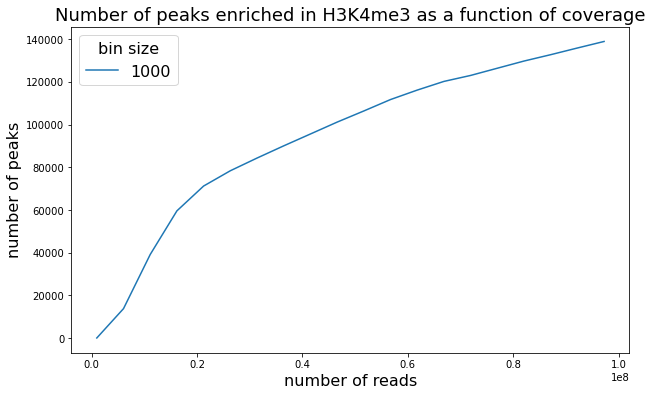

In [23]:
# key = 'p'
plt.figure(figsize=(10, 6))
for b in binsizes[1:-2]:
    plt.plot(H3K4me3_enrichments.loc[b, 'total_cov'], H3K4me3_enrichments.loc[b, 'IP_clust'], label=b)
plt.legend(fontsize=16, title='bin size', title_fontsize=16)
plt.title(f'Number of peaks enriched in H3K4me3 as a function of coverage', fontsize=18)
# plt.title(f'Number of bin clusters enriched in {data} using {key}-value, as a function of coverage', fontsize=18)
plt.xlabel('number of reads', fontsize=16)
plt.ylabel('number of peaks', fontsize=16)
# plt.yscale('log')
# fig_name = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_n_clusters_vs_coverage_v5_{key}val.png')
# fig_name = utils.safe_filename(fig_name)
# plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

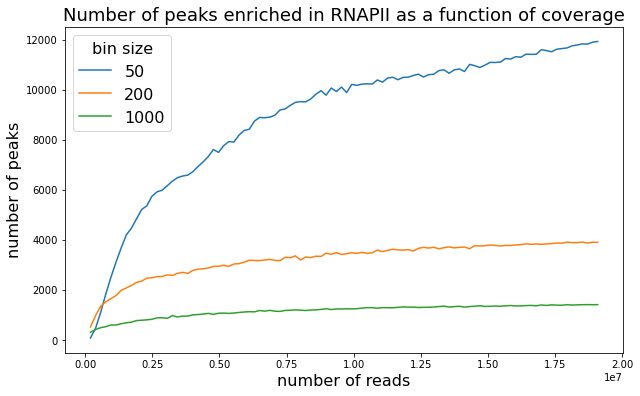

In [18]:
key = 'p'
plt.figure(figsize=(10, 6))
for b in [50, 200, 1000]:#binsizes:
    plt.plot(RNAPII_enrichments[key].loc[b, 'total_cov'], RNAPII_enrichments[key].loc[b, 'IP_clust'], label=b)
plt.legend(fontsize=16, title='bin size', title_fontsize=16)
plt.title(f'Number of peaks enriched in RNAPII as a function of coverage', fontsize=18)
# plt.title(f'Number of bin clusters enriched in {data} using {key}-value, as a function of coverage', fontsize=18)
plt.xlabel('number of reads', fontsize=16)
plt.ylabel('number of peaks', fontsize=16)
# plt.yscale('log')
# fig_name = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_n_clusters_vs_coverage_v5_{key}val.png')
# fig_name = utils.safe_filename(fig_name)
# plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

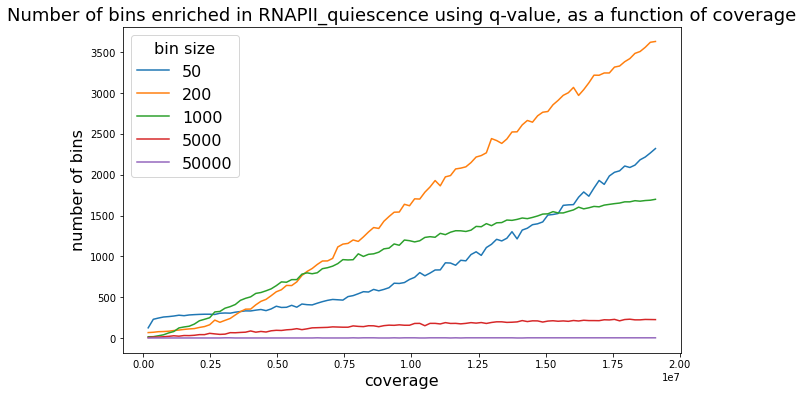

In [44]:
key = 'q'
plt.figure(figsize=(10, 6))
for b in binsizes:
    plt.plot(RNAPII_enrichments[key].loc[b, 'total_cov'], RNAPII_enrichments[key].loc[b, 'IP'], label=b)
plt.legend(fontsize=16, title='bin size', title_fontsize=16)
plt.title(f'Number of bins enriched in {data} using {key}-value, as a function of coverage', fontsize=18)
plt.xlabel('coverage', fontsize=16)
plt.ylabel('number of bins', fontsize=16)
# plt.yscale('log')
fig_name = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_n_bins_vs_coverage_v5_{key}val.png')
fig_name = utils.safe_filename(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

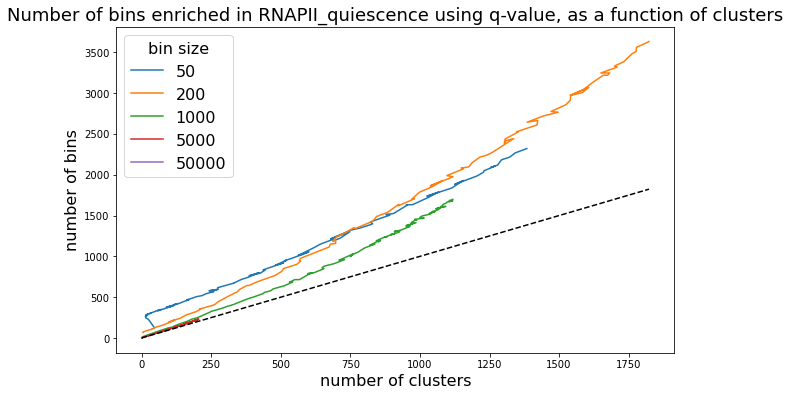

In [43]:
key = 'q'
plt.figure(figsize=(10, 6))
for b in binsizes:
    plt.plot(RNAPII_enrichments[key].loc[b, 'IP_clust'], RNAPII_enrichments[key].loc[b, 'IP'], label=b)
max_clust = np.max(RNAPII_enrichments[key]['IP_clust'])
plt.plot([0, max_clust], [0, max_clust], color='black', linestyle='--')
plt.legend(fontsize=16, title='bin size', title_fontsize=16)
plt.title(f'Number of bins enriched in {data} using {key}-value, as a function of clusters', fontsize=18)
plt.xlabel('number of clusters', fontsize=16)
plt.ylabel('number of bins', fontsize=16)
# plt.yscale('log')
fig_name = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_n_bins_vs_n_clusters_v5_{key}val.png')
fig_name = utils.safe_filename(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

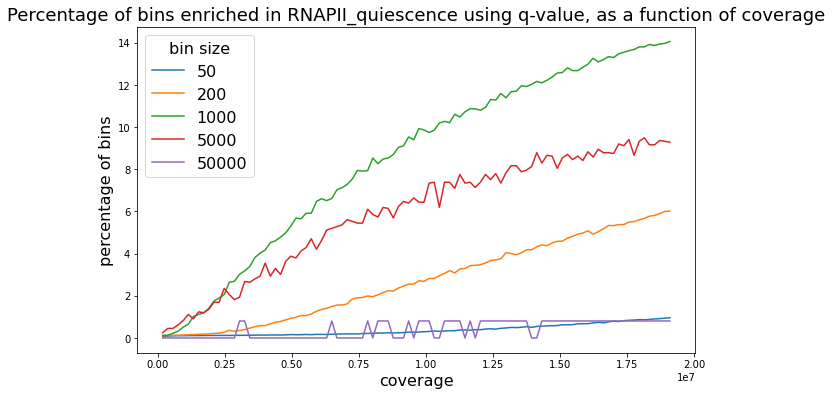

In [42]:
key = 'q'
plt.figure(figsize=(10, 6))
for b in binsizes[:]:
    plt.plot(RNAPII_enrichments[key].loc[b, 'total_cov'], RNAPII_enrichments[key].loc[b, 'IP_perc'], label=b)
plt.legend(fontsize=16, title='bin size', title_fontsize=16)
plt.title(f'Percentage of bins enriched in {data} using {key}-value, as a function of coverage', fontsize=18)
plt.xlabel('coverage', fontsize=16)
plt.ylabel('percentage of bins', fontsize=16)
# plt.yscale('log')
fig_name = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_bin_percentage_vs_coverage_v5_{key}val.png')
fig_name = utils.safe_filename(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

## Rechem comparisons

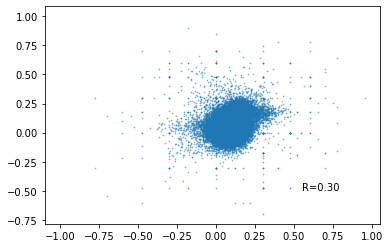

In [62]:
i = 3
Rechem_rep1 = H3K9me3_Rechem[i]['log_ratio']
Rechem_rep2 = H3K9me3_Rechem[i+4]['log_ratio']
valid_bins = np.logical_and(np.isfinite(Rechem_rep1), np.isfinite(Rechem_rep2))
corr, _ = pearsonr(Rechem_rep1[valid_bins], Rechem_rep2[valid_bins])
plt.scatter(Rechem_rep1, Rechem_rep2, s=0.5, alpha=0.5)
plt.annotate('R={0:1.2f}'.format(corr), xy = (0.7, 0.2), xycoords = 'figure fraction')
plt.plot([-1, -1], [1, 1], color='black')#, alpha=0.5)
plt.show()
plt.close()

Number of reads

In [41]:
print(np.sum(full_genome_H3K9me3['ip_binned_signal']), 'in H3K9me3')
print(np.sum(full_genome_H3K9me3['ctrl_binned_signal']), 'in INPUT-H3K9me3')
print(np.sum(full_genome_H3K4me3['ip_binned_signal']), 'in H3K4me3')
print(np.sum(full_genome_H3K4me3['ctrl_binned_signal']), 'in INPUT-H3K4me3')
data = 'H3K9me3-GSE175752'
for i, H3K9me3_Rsingle in enumerate(H3K9me3_Rechem):
    print(np.sum(H3K9me3_Rsingle['ip_binned_signal']), f' in {data}-SRR1467833{i+8}')
    print(np.sum(H3K9me3_Rsingle['ctrl_binned_signal']), f' in INPUT-{data}-SRR1467833{i+8}')

53399358.0 in H3K9me3
43781228.0 in INPUT-H3K9me3
52844132.0 in H3K4me3
44410565.0 in INPUT-H3K4me3
29657910.0  in H3K9me3-GSE175752-SRR14678338
25426870.0  in INPUT-H3K9me3-GSE175752-SRR14678338
26175159.0  in H3K9me3-GSE175752-SRR14678339
21063530.0  in INPUT-H3K9me3-GSE175752-SRR14678339
22606816.0  in H3K9me3-GSE175752-SRR146783310
25035217.0  in INPUT-H3K9me3-GSE175752-SRR146783310
28199410.0  in H3K9me3-GSE175752-SRR146783311
21901600.0  in INPUT-H3K9me3-GSE175752-SRR146783311
26626674.0  in H3K9me3-GSE175752-SRR146783312
27302126.0  in INPUT-H3K9me3-GSE175752-SRR146783312
34406481.0  in H3K9me3-GSE175752-SRR146783313
32337947.0  in INPUT-H3K9me3-GSE175752-SRR146783313
23176481.0  in H3K9me3-GSE175752-SRR146783314
30195088.0  in INPUT-H3K9me3-GSE175752-SRR146783314
44731176.0  in H3K9me3-GSE175752-SRR146783315
34051616.0  in INPUT-H3K9me3-GSE175752-SRR146783315


In [110]:
df_Rechem_pooled = utils.pool_experiments(H3K9me3_Rechem)
print(np.sum(df_Rechem_pooled['ip_binned_signal']), 'in H3K9me3')
df_Rechem_pooled

13564/62359 significantly enriched bins in H3K9me3-GSE175752
235580107.0 in H3K9me3


,pos,ip_binned_signal,ctrl_binned_signal,binom_p_value_complete,binom_q_value_complete,-log(qvalue_complete),-log(pvalue_complete),significantly_enriched
0,0.0,5264.0,5380.0,1.000000,1.000000,-0.000000,2.556282e-08,False
1,50000.0,3778.0,3481.0,0.484929,1.000000,-0.000000,3.143217e-01,False
2,100000.0,3203.0,3077.0,0.947372,1.000000,-0.000000,2.347965e-02,False
3,150000.0,2581.0,2510.0,0.971139,1.000000,-0.000000,1.271843e-02,False
4,200000.0,2484.0,2498.0,0.998896,1.000000,-0.000000,4.799255e-04,False
...,...,...,...,...,...,...,...,...
62354,62250000.0,3157.0,2844.0,0.183022,0.622957,0.205542,7.374958e-01,False
62355,62300000.0,3039.0,2712.0,0.107245,0.392470,0.406193,9.696229e-01,False
62356,62350000.0,3361.0,2952.0,0.026644,0.113051,0.946725,1.574395e+00,False
62357,62400000.0,3025.0,2860.0,0.830714,1.000000,-0.000000,8.054829e-02,False


<AxesSubplot:>

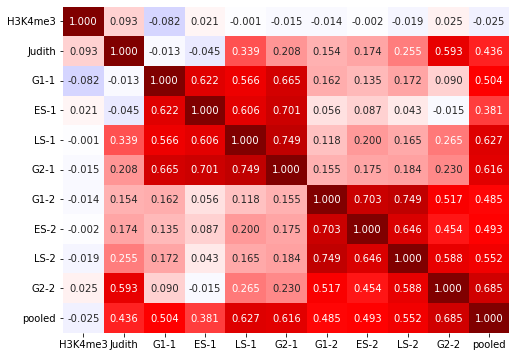

In [112]:
column = '-log_qval'
df_H3K9me3_compare = pd.DataFrame({'H3K4me3' : df_H3K4me3[column],
                                   'Judith' : df_H3K9me3[column]})
setups = np.array(['H3K4me3', 'Judith', 'G1-1', 'ES-1', 'LS-1', 'G2-1', 'G1-2', 'ES-2', 'LS-2', 'G2-2', 'pooled'])
for i in range(8):
    df_H3K9me3_compare[f'Rechem_{setups[i+1]}'] = H3K9me3_Rechem[i][column]
df_H3K9me3_compare['Rechem_pooled'] = df_Rechem_pooled[column]

corrs = np.corrcoef(df_H3K9me3_compare, rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corrs, vmin=-1, vmax=1, annot=True, fmt='.3f',
            cmap=plt.cm.get_cmap('seismic'), cbar=False,
            xticklabels=setups, yticklabels=setups)

Autocorrelation

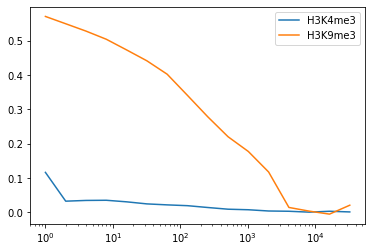

In [15]:
lags = 2**np.arange(16)
autocorrs_H3K4me3 = []
autocorrs_H3K9me3 = []
for lag in lags:
    autocorrs_H3K4me3.append(df_H3K4me3['-log_qval'].astype(float).autocorr(lag=lag))
    autocorrs_H3K9me3.append(df_H3K9me3['-log_qval'].astype(float).autocorr(lag=lag))
plt.plot(lags, autocorrs_H3K4me3, label='H3K4me3')
plt.plot(lags, autocorrs_H3K9me3, label='H3K9me3')
plt.xscale('log')
plt.legend()
plt.show()
plt.close()

#### Old plots

Plot of raw signal

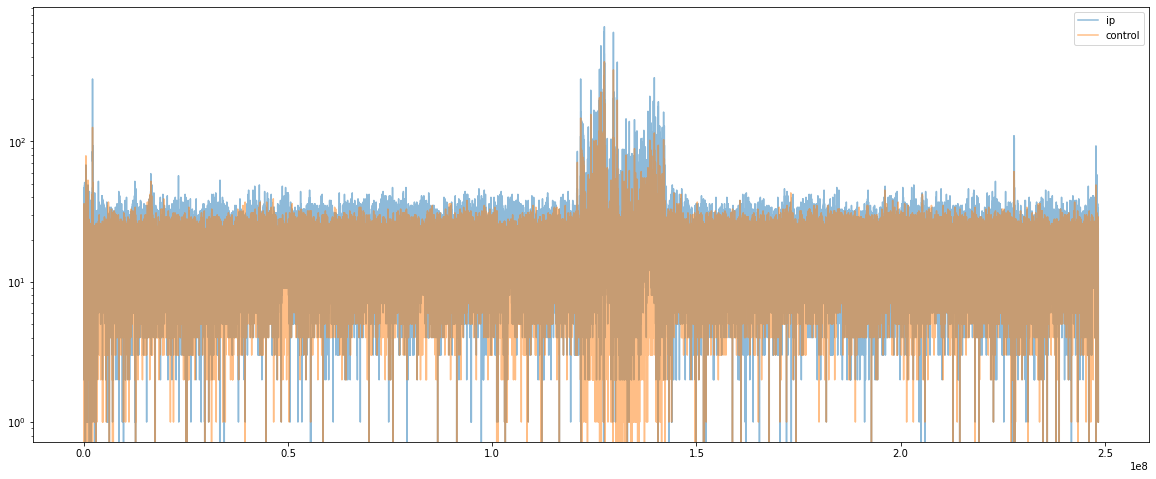

In [206]:
start = 0  # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
plt.plot(np.arange(bin_start, bin_end, bins), ip_binned_signal_chr[start//bins:end//bins], label='ip', alpha=0.5)
plt.plot(np.arange(bin_start, bin_end, bins), ctrl_binned_signal_chr[start//bins:end//bins], label='control', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ip2_binned_signal_chr[start//bins:end//bins], label='ip2', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ctrl2_binned_signal_chr[start//bins:end//bins], label='control2', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ctrl3_binned_signal_chr[start//bins:end//bins], label='control3', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [4]:
data3 = "Judith-H3K27me3"
bins = 1000
chr_id = 1
df = pd.read_csv(f'{data_dir}/{data3}/results/All_chr{chr_id}_binned_{bins}.csv', index_col=0)

<AxesSubplot:>

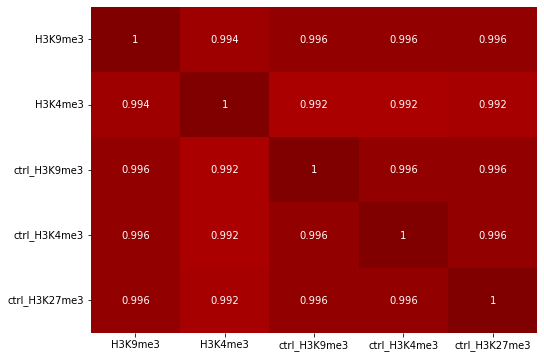

In [ ]:
corrs = np.corrcoef(df.iloc[:,1:], rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corrs, vmin=0.9, vmax=1, annot=True, fmt='.3g',
            cmap=plt.cm.get_cmap('seismic'), cbar=False,
            xticklabels=df.columns[1:], yticklabels=df.columns[1:])

Processed signals

In [ ]:
def KL(x, y):
    return x * np.log10(x / y)

df['KL_H3K4me3_ctrl4'] = KL(df['H3K4me3'], df['ctrl_H3K4me3'])
df['KL_H3K4me3_ctrl9'] = KL(df['H3K4me3'], df['ctrl_H3K9me3'])
df['KL_H3K4me3_ctrl27'] = KL(df['H3K4me3'], df['ctrl_H3K27me3'])
df['KL_H3K9me3_ctrl4'] = KL(df['H3K9me3'], df['ctrl_H3K4me3'])
df['KL_H3K9me3_ctrl9'] = KL(df['H3K9me3'], df['ctrl_H3K9me3'])
df['KL_H3K9me3_ctrl27'] = KL(df['H3K9me3'], df['ctrl_H3K27me3'])


/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(230014, 12)
(230220, 12)


<AxesSubplot:>

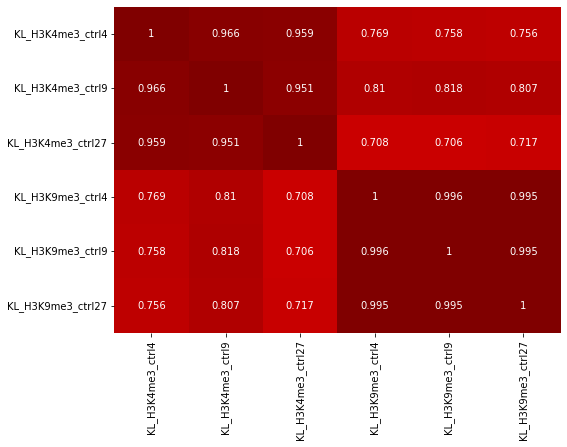

In [ ]:
df2 = df.where(np.isfinite(df)).dropna()
print(df2.shape)
print(df.shape)
corrs_processed = np.corrcoef(df2.iloc[:,6:], rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corrs_processed, vmin=-1, vmax=1, annot=True, fmt='.3g',
            cmap=plt.cm.get_cmap('seismic'), cbar=False,
            xticklabels=df2.columns[6:], yticklabels=df2.columns[6:])

/tmp/ipykernel_240455/2711071431.py:5: RuntimeWarning: divide by zero encountered in log10
  values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]


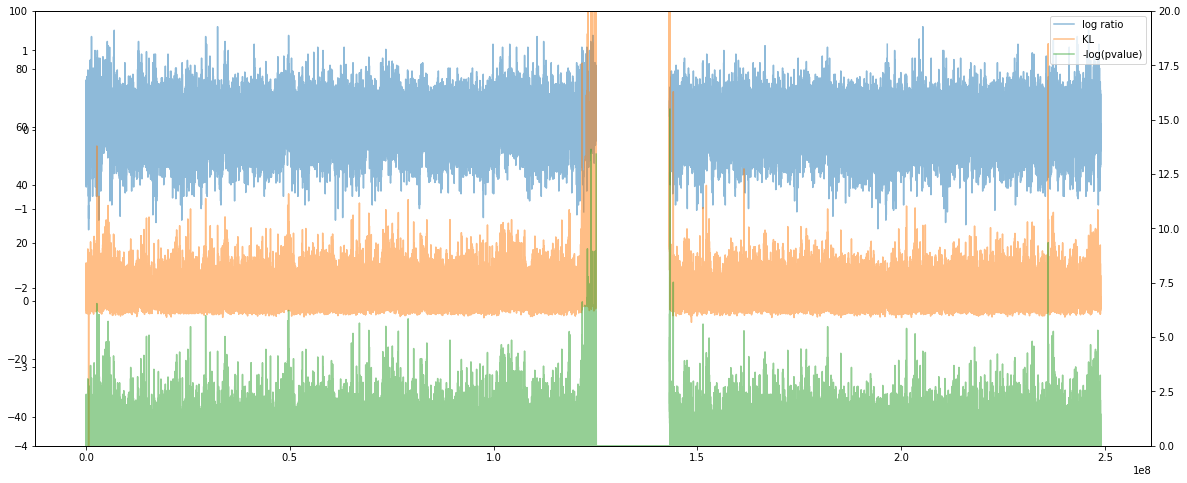

In [290]:
importlib.reload(plot_utils)
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=1.5)
axes[1].set_ylim(bottom=-50, top=100)
axes[2].set_ylim(bottom=0, top=20)
plt.show()
plt.close()

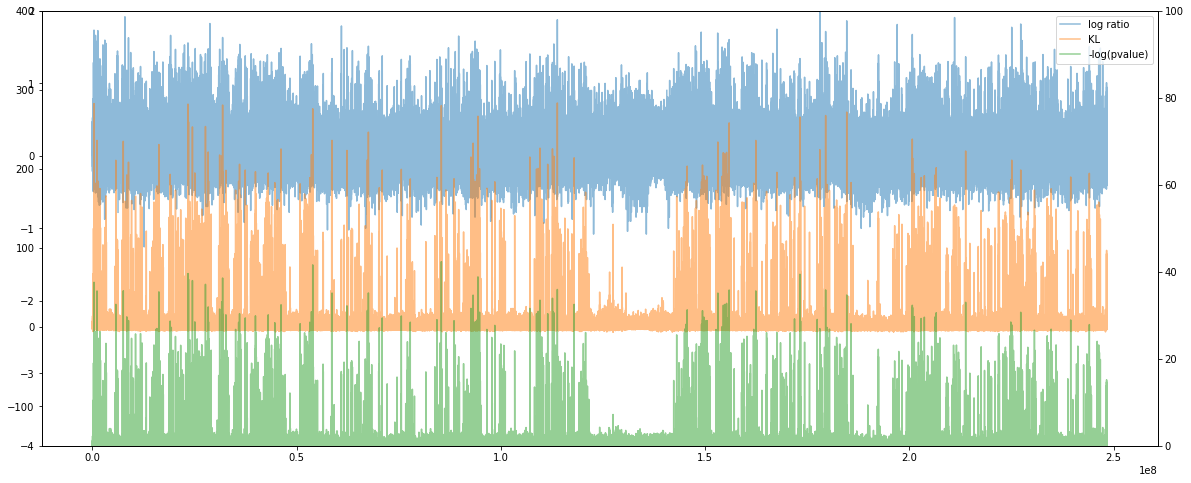

In [155]:
importlib.reload(plot_utils)
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


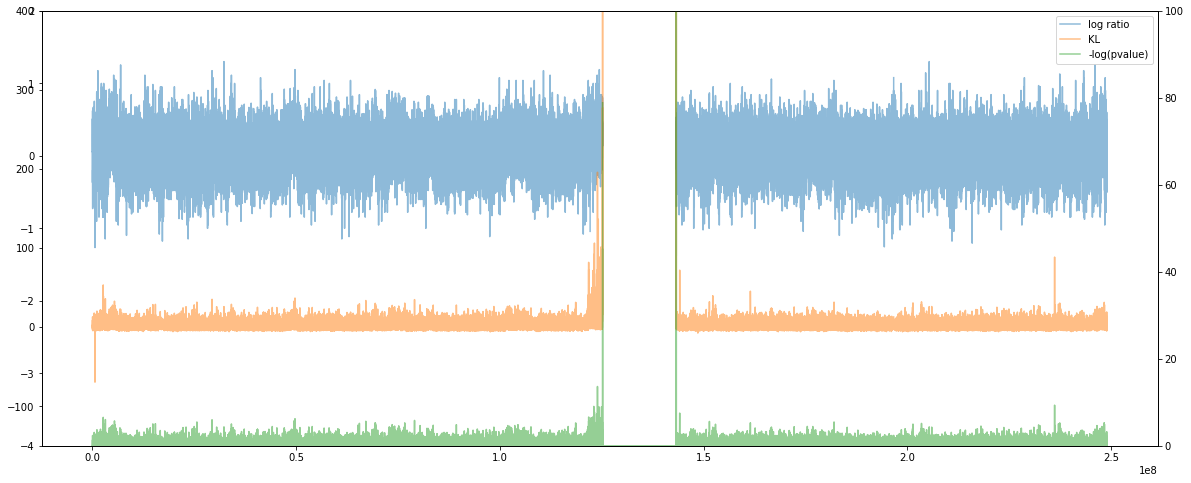

In [182]:
data = 'Judith-H3K9me3'
df = pd.read_csv(f'{data_dir}/{data}/results/alignments/GRCh38/{data}_chr{chr_id}_binned_{bins}.csv')
ip_binned_signal_chr = df['ip_binned_signal']
log_ratio_chr = df['log_ratio']
KL_chr = df['KL']
p_vals = df['binom_p_value']
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

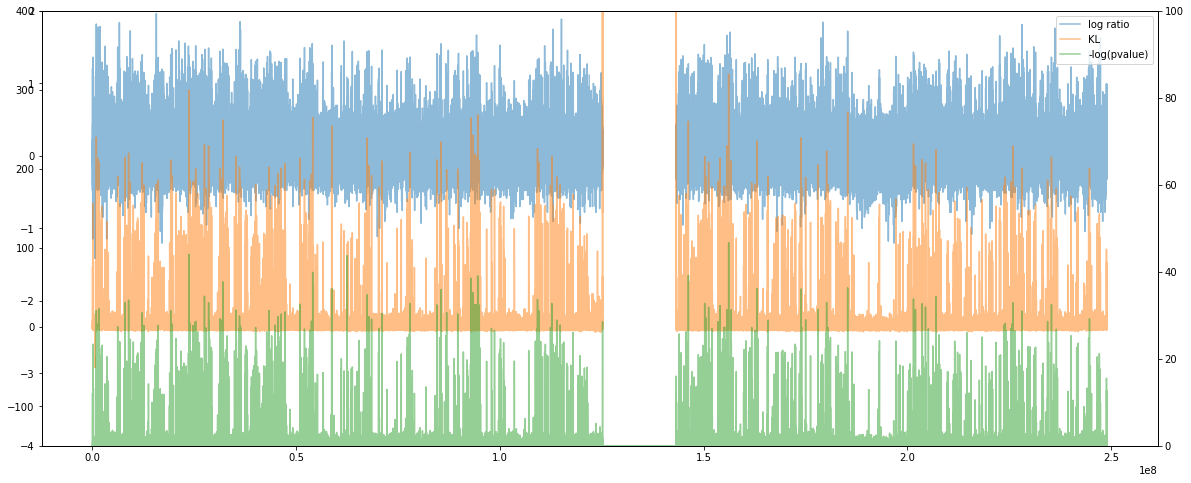

In [183]:
data = 'Judith-H3K4me3'
df = pd.read_csv(f'{data_dir}/{data}/results/alignments/GRCh38/{data}_chr{chr_id}_binned_{bins}.csv')
ip_binned_signal_chr = df['ip_binned_signal']
log_ratio_chr = df['log_ratio']
KL_chr = df['KL']
p_vals = df['binom_p_value']
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ['log ratio', 'KL', '-log(pvalue)']
axes = plot_utils.compare_binned_plots(values_list, label_list, start, end, bins, alpha=0.5)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

Correlation between processed signals

In [156]:
valid_bins = np.logical_and(np.isfinite(KL_chr), np.isfinite(-np.log10(p_vals)))
print(pearsonr(KL_chr[valid_bins], -np.log10(p_vals)[valid_bins]))
print(pearsonr(KL_chr[valid_bins], log_ratio_chr[valid_bins]))
print(pearsonr(-np.log10(p_vals)[valid_bins], log_ratio_chr[valid_bins]))

(0.9912833207835683, 0.0)
(0.6653103968940027, 0.0)
(0.6056913679136753, 0.0)


Plot of processed signals

/tmp/ipykernel_126826/2145195069.py:11: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.arange(bin_start, bin_end, bins), -np.log10(p_vals)[start//bins:end//bins], label='-log(pvalue)', alpha=0.5, color=colors[2])


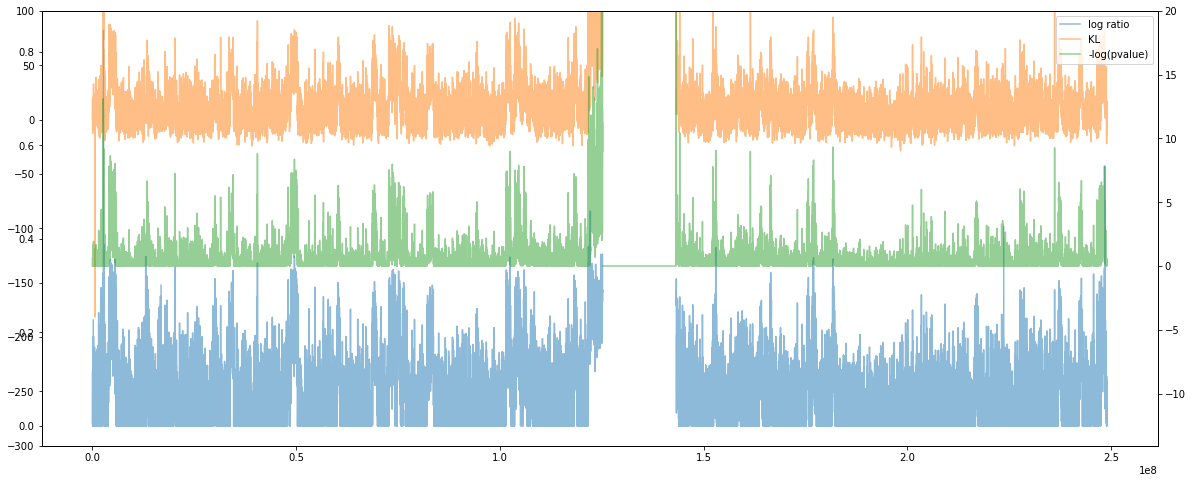

In [ ]:
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.plot(np.arange(bin_start, bin_end, bins), np.maximum(log_ratio_chr[start//bins:end//bins], 0), label='log ratio', alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(np.arange(bin_start, bin_end, bins), KL_chr[start//bins:end//bins], label='KL', alpha=0.5, color=colors[1])
ax3 = ax2.twinx()
ax3.plot(np.arange(bin_start, bin_end, bins), -np.log10(p_vals)[start//bins:end//bins], label='-log(pvalue)', alpha=0.5, color=colors[2])
# ax1.set_ylim(bottom=-1.5)
ax2.set_ylim(bottom=-300, top=100)
ax3.set_ylim(top=20)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
plt.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3)
plt.show()
plt.close()

/tmp/ipykernel_270277/2435503918.py:5: RuntimeWarning: divide by zero encountered in log
  N = np.log(ip_binned_signal_chr)
/tmp/ipykernel_270277/2435503918.py:8: RuntimeWarning: invalid value encountered in multiply
  plt.scatter(KL_chr[start//bins:end//bins], (-np.log10(p_vals)*N)[start//bins:end//bins], c=N, cmap='YlOrRd', label='positions', alpha=0.5)


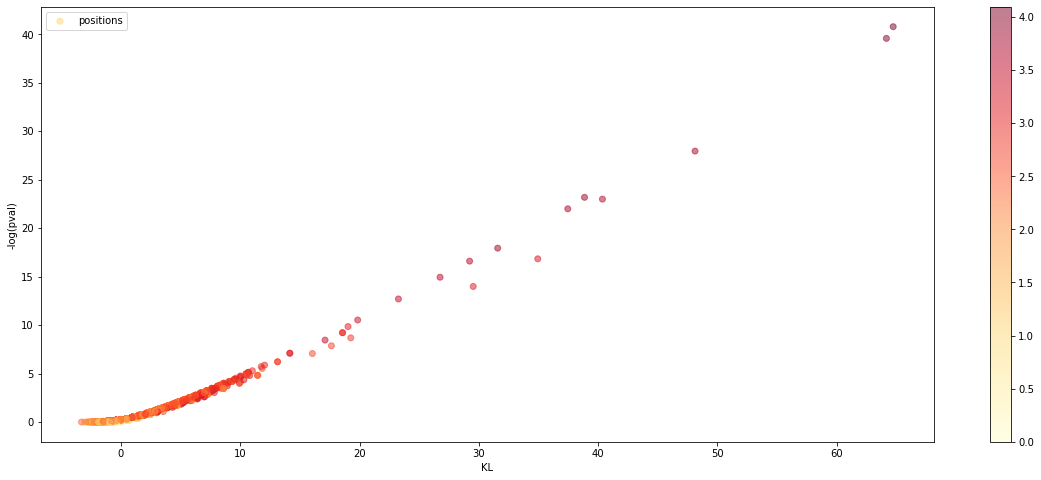

In [73]:
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
N = np.log(ip_binned_signal_chr)
plt.figure(figsize=(20, 8))
# ax1 = plt.subplot()
plt.scatter(KL_chr[start//bins:end//bins], (-np.log10(p_vals)*N)[start//bins:end//bins], c=N, cmap='YlOrRd', label='positions', alpha=0.5)
# plt.xlim(left=0, right=200)
# plt.ylim(bottom=0, top=15)
plt.xlabel('KL')
plt.ylabel('-log(pval)')
plt.legend()
plt.colorbar()
plt.show()
plt.close()

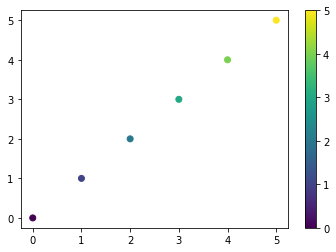

In [188]:
x = np.arange(6)
plt.scatter(x,x,c=x)
plt.colorbar()

#### Exact alignment

In [ ]:
ip_signal_chr = utils.exact_alignment_signal_from_coord(ip_coord_chr)
ctrl_signal_chr = utils.exact_alignment_signal_from_coord(ctrl_coord_chr)
print(len(ip_signal_chr), len(ctrl_signal_chr))
ip_signal_chr, ctrl_signal_chr = utils.adjust_length(ip_signal_chr, ctrl_signal_chr)
print(len(ip_signal_chr), len(ctrl_signal_chr))

248946395 248946413
248946413 248946413


In [ ]:
ip_postbinned_signal_chr = convolve(ip_signal_chr, np.ones(bins) / bins, mode='same')
ctrl_postbinned_signal_chr = convolve(ctrl_signal_chr, np.ones(bins) / bins, mode='same')

In [ ]:
postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
postbinned_KL_chr = ip_postbinned_signal_chr * np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)

# p_binom = len(ip_coord_chr) / (len(ip_coord_chr) + len(ctrl_coord_chr))
# p_vals = np.zeros(len(ip_postbinned_signal_chr))
# for i in range(len(ip_postbinned_signal_chr)):
#     n_binom = ip_postbinned_signal_chr[i] + ctrl_postbinned_signal_chr[i]
#     k_binom = ip_postbinned_signal_chr[i]
#     if n_binom >= 1:
#         res = scipy.stats.binomtest(k_binom, n_binom, p=p_binom, alternative='greater')
#         p_vals[i] = res.pvalue
#     else:
#         p_vals[i] = 1

/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: divide by zero encountered in true_divide
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: invalid value encountered in true_divide
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: divide by zero encountered in log10
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: invalid value encountered in log10
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:2: RuntimeWarning: divide by zero encountered in true_divide
  postbinned_KL_chr = ip_postbinned_signal_chr * np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:2: RuntimeWarn

In [ ]:
start = 0 # 122_000_000
end = len(ip_signal_chr)  # 40_000_000
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.plot(np.arange(start, end), ip_postbinned_signal_chr[start:end], label='ip', alpha=0.5)
repeats = utils.find_peaks_in_window(all_chr_repeats, start, end)
print(repeats.shape)
rep_height = 1
for id, (rep_start, rep_end, *_) in enumerate(repeats):
    if id == 0:
        ax1.plot([rep_start, rep_end], [rep_height, rep_height], marker = '.', color='red', label='repeats')
    else:
        ax1.plot([rep_start, rep_end], [rep_height, rep_height], marker = '.', color='red')
# plt.plot(np.arange(start, end), ctrl_signal_chr[start:end], label='control', alpha=0.5)
ax1.set_yscale('log')
# handles1, labels1 = ax1.get_legend_handles_labels()
plt.legend(loc="upper right")
plt.show()
plt.close()

(444217, 2)


: 

: 

## Tests

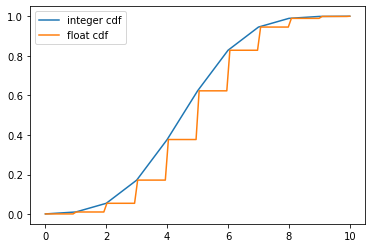

In [ ]:
res_int = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 10, 0.5)
res_nonint = scipy.stats.binom.cdf(np.linspace(0, 10, 100), 10, 0.5)
plt.plot(np.linspace(0, 10, 11), res_int, label='integer cdf')
plt.plot(np.linspace(0, 10, 100), res_nonint, label='float cdf')
plt.legend()
plt.show()
plt.close()

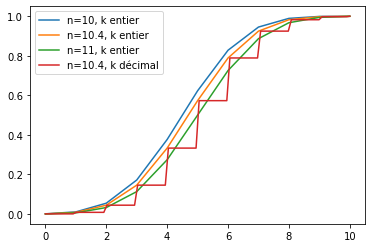

In [ ]:
res_int = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 10, 0.5)
res_nonint = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 10.4, 0.5)
res_int2 = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 11, 0.5)
res_nonint2 = scipy.stats.binom.cdf(np.linspace(0, 10, 100), 10.4, 0.5)
plt.plot(np.linspace(0, 10, 11), res_int, label='n=10, k entier')
plt.plot(np.linspace(0, 10, 11), res_nonint, label='n=10.4, k entier')
plt.plot(np.linspace(0, 10, 11), res_int2, label='n=11, k entier')
plt.plot(np.linspace(0, 10, 100), res_nonint2, label='n=10.4, k décimal')
plt.legend()
plt.show()
plt.close()

In [ ]:
def fdr_bh(p):
    q = np.copy(p)
    # sort
    order = np.argsort(q)
    q = q[order]
    # compute p_value correction
    q = np.minimum(q*len(q)/np.arange(1, len(q)+1), 1)
    # preserve order by taking min of upper values
    q[::-1] = np.minimum.accumulate(q[::-1])
    # unsort before output
    return q[np.argsort(order)]

my_qval_H3K4me3 = fdr_bh(df_H3K4me3['pval'])

assert np.allclose(my_qval_H3K4me3, df_H3K4me3['qval'])

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(df_H3K4me3['qval'], my_qval_H3K4me3)
plt.xlabel("scipy's q_value implementation", fontsize=14)
plt.ylabel("my q_value implementation", fontsize=14)
# plt.xscale('log')
# plt.yscale('log')
plt.show()
plt.close()